# Importing the necessary libraries

In [69]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.decomposition import PCA
%matplotlib inline

# Reading the CSV files

In [70]:
sample = pd.read_csv('wells_fargo_sample_submission.csv')
test = pd.read_csv('wells_fargo_test.csv')
train = pd.read_csv('wells_fargo_train.csv')

# Viewing the train dataset

In [71]:
train

,Id,Fiscal Year,Term Type,Career,Program Level,Study Year,Campus_Id,Faculty Group,Program Grouping,Coop Regular,WorkTerm,Attendance,Visa Status,Gender,Unique Headcount
0,0,2008/09,Fall term,Graduate,Doctoral,D,4,AHS,"Aging, Health and Well-Being",Regular,Academic Term,Full-Time,Canadian,Male,5
1,1,2008/09,Fall term,Graduate,Doctoral,D,4,AHS,"Aging, Health and Well-Being",Regular,Academic Term,Full-Time,Canadian,Female,7
2,2,2008/09,Fall term,Graduate,Doctoral,D,4,AHS,"Aging, Health and Well-Being",Regular,Academic Term,Full-Time,International,Female,1
3,3,2008/09,Fall term,Graduate,Doctoral,D,4,AHS,Health Studies and Gerontology,Regular,Academic Term,Full-Time,Canadian,Male,3
4,4,2008/09,Fall term,Graduate,Doctoral,D,4,AHS,Health Studies and Gerontology,Regular,Academic Term,Full-Time,Canadian,Female,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72244,72244,2014/15,Winter term,Undergraduate,Non-Degree,N,4,SCI,Science,Regular,Academic Term,Part-Time,Canadian,Male,25
72245,72245,2014/15,Winter term,Undergraduate,Non-Degree,N,4,SCI,Science,Regular,Academic Term,Part-Time,Canadian,Female,27
72246,72246,2014/15,Winter term,Undergraduate,Non-Degree,N,4,SCI,Science,Regular,Academic Term,Part-Time,Canadian Permanent Resident,Female,1
72247,72247,2014/15,Winter term,Undergraduate,Non-Degree,N,4,SCI,Science,Regular,Academic Term,Part-Time,International,Male,30


# We infer that
- Id column is not necessary for our prediction, so we drop it
- Campus Id although continuous is by intuition a categorical variable, so we convert it to string

In [72]:
train = train.drop(['Id'],axis=1)
train['Campus_Id'] = train['Campus_Id'].apply(lambda x: str(x))
test_id = test["Id"]
test["Campus_Id"] = test["Campus_Id"].apply(lambda x:str(x))
test = test.drop("Id",axis=1)

# Here we plot the countplot of the train and test to check if the distributions are the same

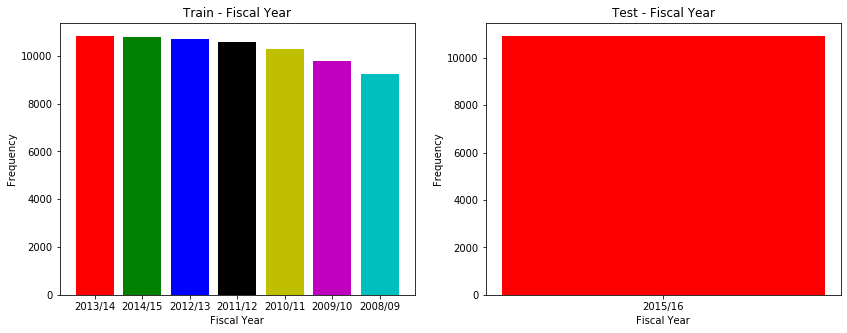

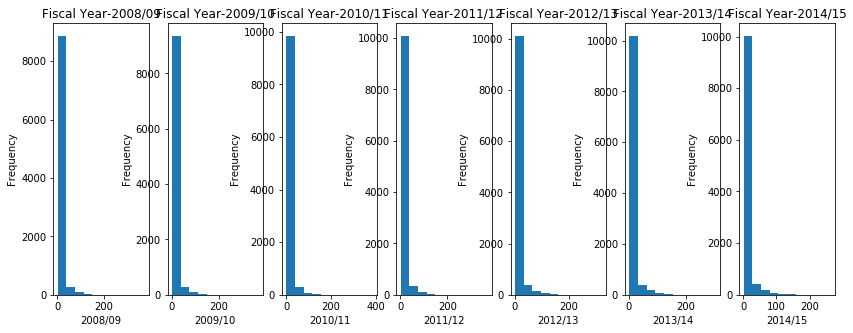

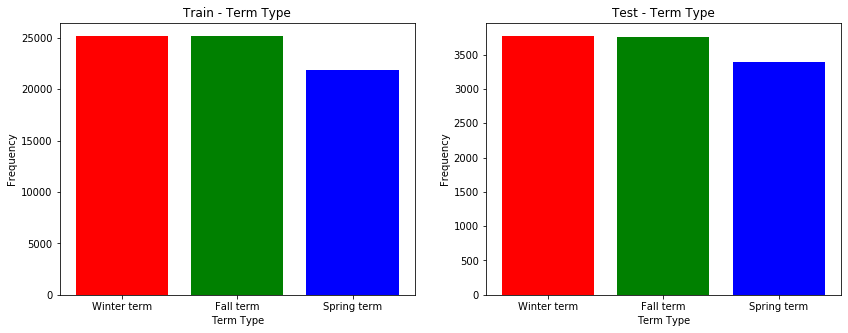

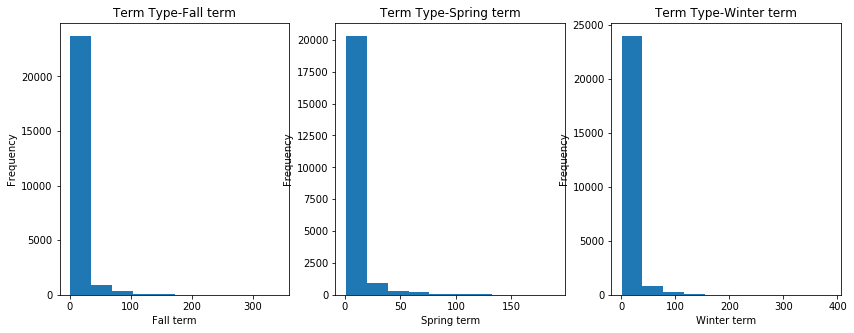

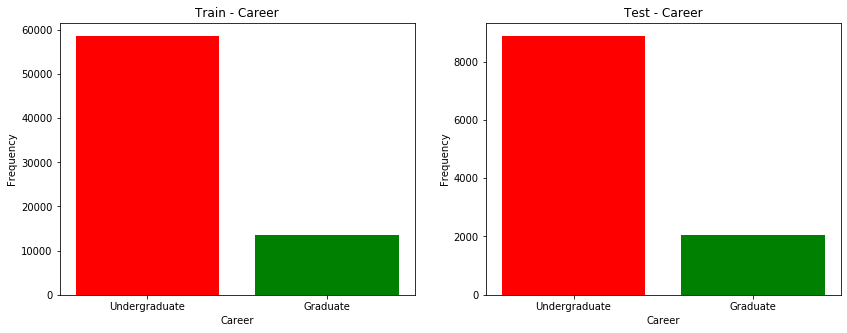

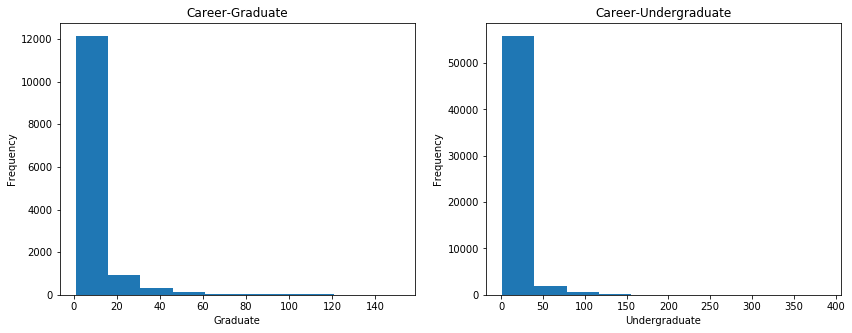

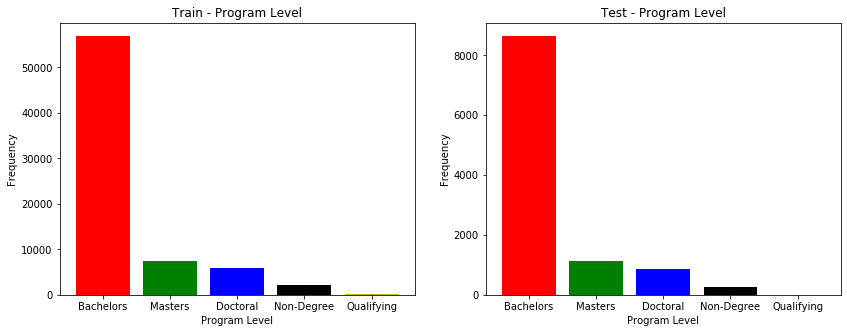

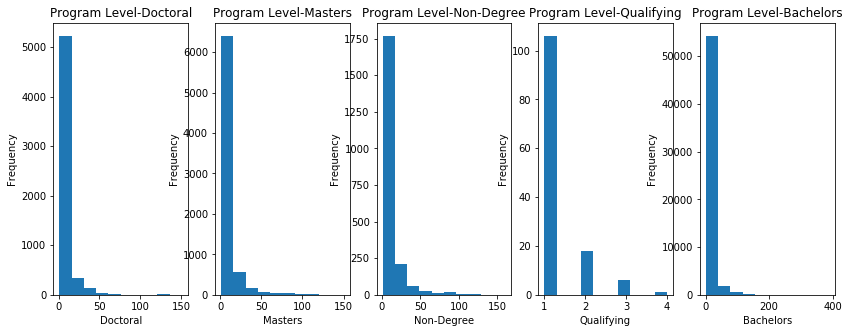

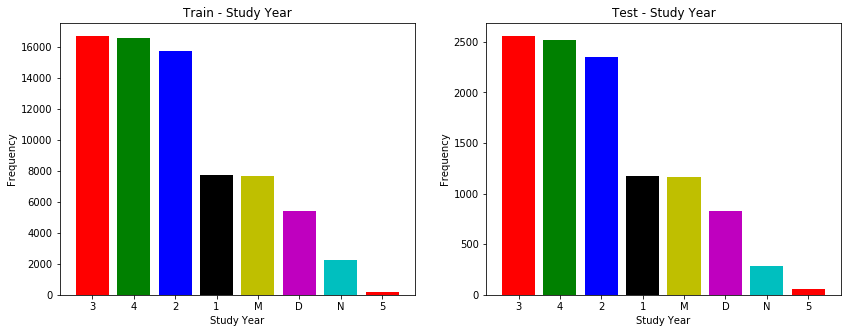

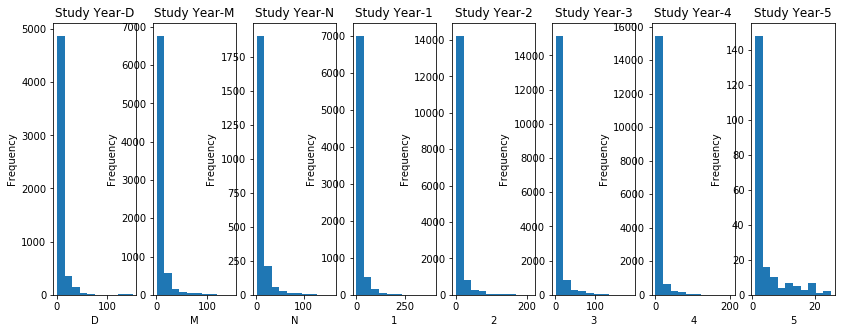

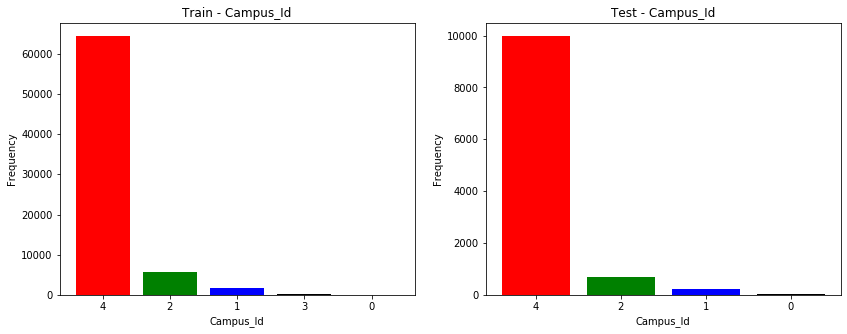

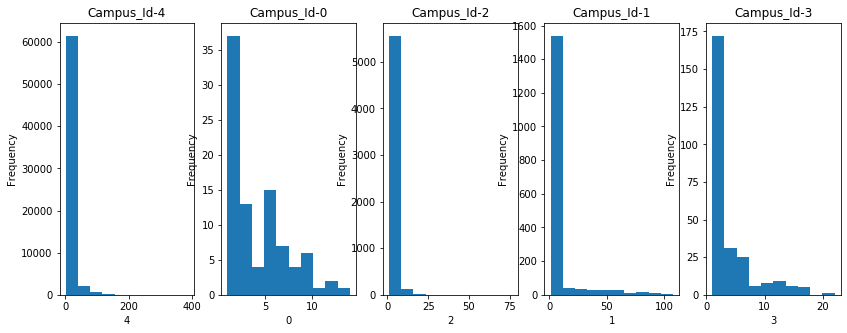

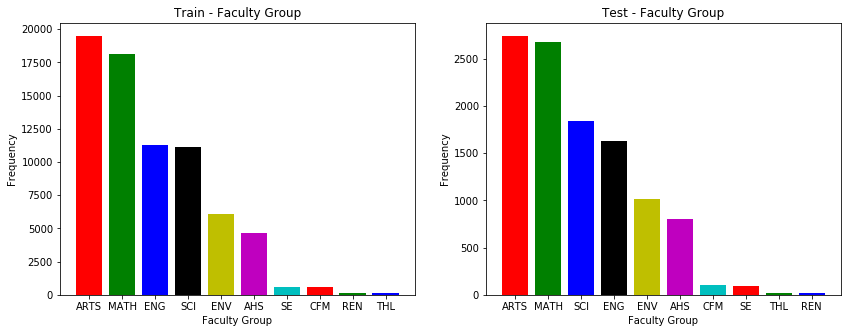

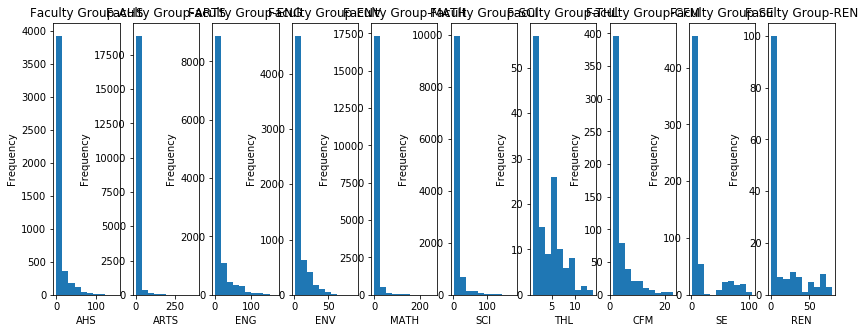

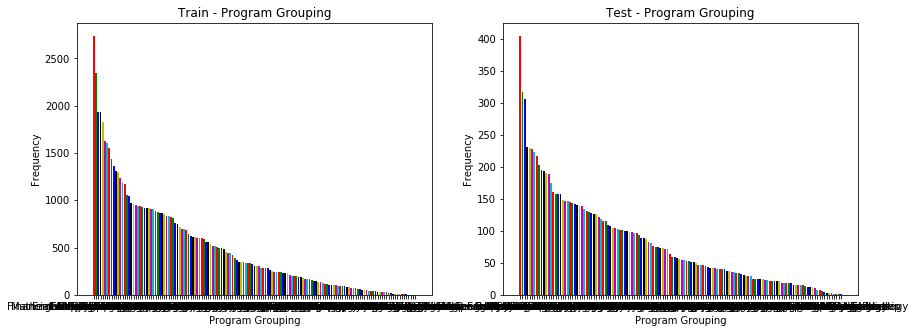

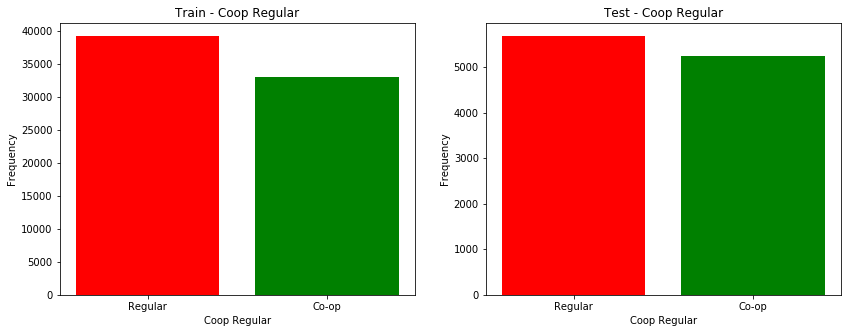

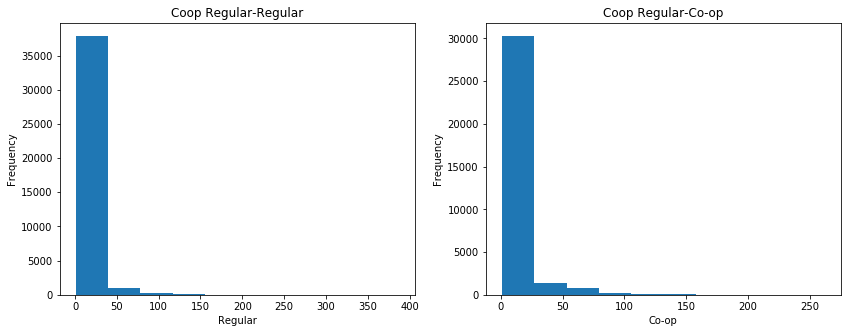

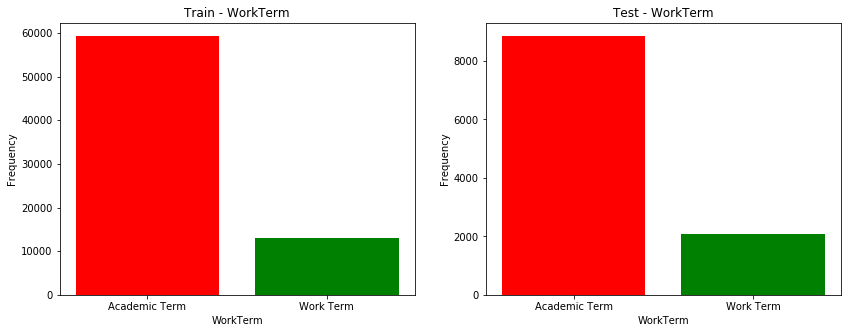

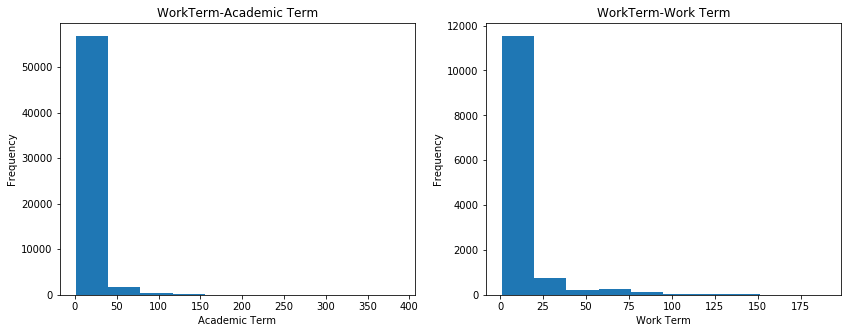

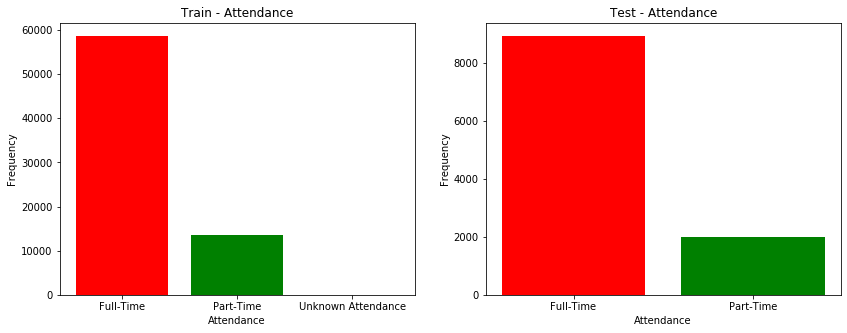

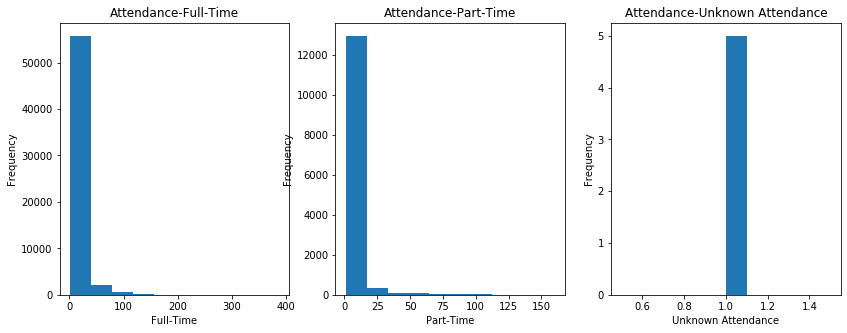

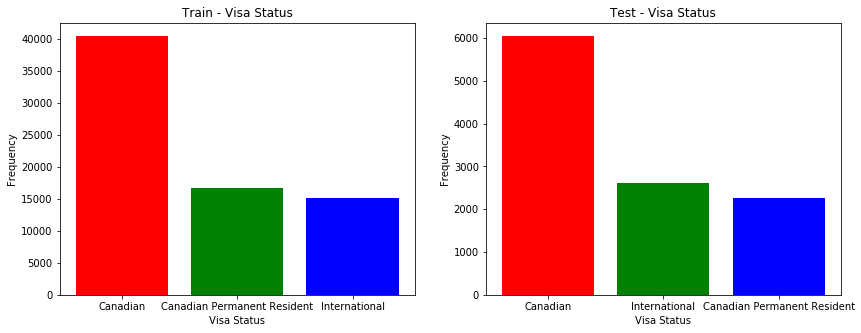

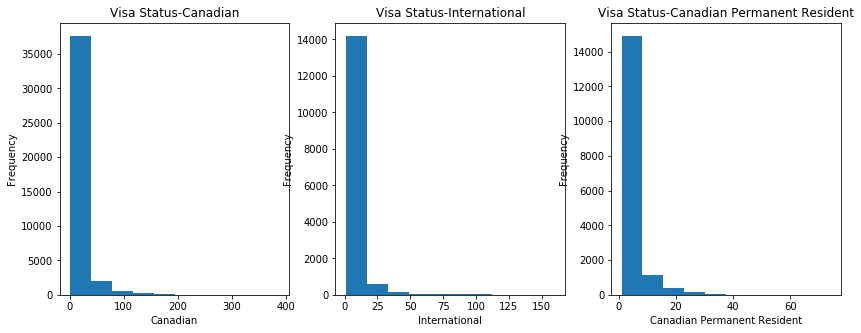

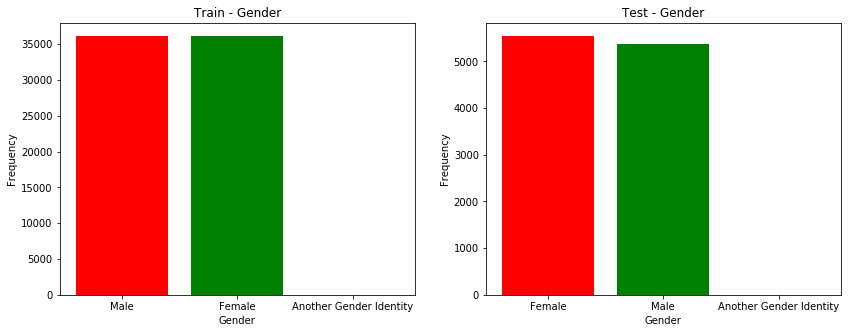

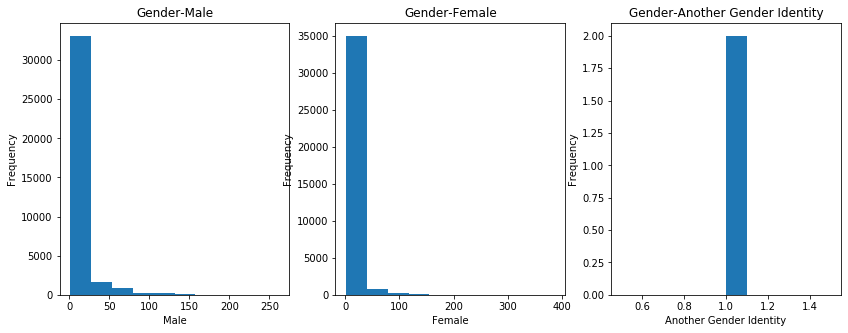

In [73]:
for i in train.columns[:-1]:
    train_i = pd.DataFrame(train[i].value_counts())
    test_i = pd.DataFrame(test[i].value_counts())
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.bar(train_i.index,train_i[i],color='rgbkymc')
    plt.title("Train - "+i)
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.subplot(1,2,2)
    plt.bar(test_i.index,test_i[i],color='rgbkymc')
    plt.title("Test - "+i)
    plt.xlabel(i)
    plt.ylabel("Frequency")
    if i!="Program Grouping":
        plt.figure(figsize=(14,5))
        for j in range(len(train[i].unique())):
            plt.subplot(1,len(train[i].unique()),j+1)
            plt.hist(train[train[i]==train[i].unique()[j]]["Unique Headcount"])
            plt.title(i+'-'+train[i].unique()[j])
            plt.xlabel(train[i].unique()[j])
            plt.ylabel("Frequency")
#             print(train[train[i]==train[i].unique()[j]]["Unique Headcount"].describe())
    plt.show()

# From the above we find that 
- The train dataset contains data of the Fiscal Years 2008/09-2013/14
- The test dataset contains data of the Fiscal Year 2015/16 alone
- Most columns have a similar distribution of variables except for a few where the test set does not have the variable itself

In [74]:
test_stats = test.describe().transpose()
train_stats = train.describe(include=["O"]).transpose()
test_stats["freq"] = test_stats["freq"].apply(lambda x: 100*x/test.shape[0])
train_stats["freq"] = train_stats["freq"].apply(lambda x: 100*x/train.shape[0])
test_stats

,count,unique,top,freq
Fiscal Year,10924,1,2015/16,100.000000
Term Type,10924,3,Winter term,34.520322
Career,10924,2,Undergraduate,81.288905
Program Level,10924,5,Bachelors,79.192603
Study Year,10924,8,3,23.407177
Campus_Id,10924,4,4,91.385939
Faculty Group,10924,10,ARTS,25.100696
Program Grouping,10924,136,Computer Science,3.707433
Coop Regular,10924,2,Regular,52.041377
WorkTerm,10924,2,Academic Term,81.023435


In [75]:
train_stats

,count,unique,top,freq
Fiscal Year,72249,7,2013/14,15.000900
Term Type,72249,3,Winter term,34.861382
Career,72249,2,Undergraduate,81.123614
Program Level,72249,5,Bachelors,78.762336
Study Year,72249,8,3,23.097898
Campus_Id,72249,5,4,89.165248
Faculty Group,72249,10,ARTS,26.988609
Program Grouping,72249,147,Computer Science,3.788288
Coop Regular,72249,2,Regular,54.265111
WorkTerm,72249,2,Academic Term,82.113247


- Luckily for us there are no missing values, and the frequencies of the most common value doesn't differ
- Unluckiliy for us, like mentioned earlier, the number of unique values in each column differs in the test and train, this might pose a problem

# Converting all the categorical columns into one-hot so we can use it for computations

In [76]:
cols = train.columns
for j in cols[:-1]:
    col = list(train[j].unique())
    for i in test[j].unique():
        if i not in col:
            col.append(i)
    for i in col:
        train[j+"-"+i] = train[j].apply(lambda x: 1 if x==i else 0)
        test[j+"-"+i] = test[j].apply(lambda x: 1 if x==i else 0)
        
headcount = train["Unique Headcount"]
train = train.drop(cols,axis=1)
test = test.drop(cols[:-1],axis=1)
train["Unique Headcount"] = headcount

# Checking if it has worked properly

In [77]:
train.shape[1]==test.shape[1]+1

True

In [78]:
train

,Fiscal Year-2008/09,Fiscal Year-2009/10,Fiscal Year-2010/11,Fiscal Year-2011/12,Fiscal Year-2012/13,Fiscal Year-2013/14,Fiscal Year-2014/15,Fiscal Year-2015/16,Term Type-Fall term,Term Type-Spring term,...,Attendance-Full-Time,Attendance-Part-Time,Attendance-Unknown Attendance,Visa Status-Canadian,Visa Status-International,Visa Status-Canadian Permanent Resident,Gender-Male,Gender-Female,Gender-Another Gender Identity,Unique Headcount
0,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,5
1,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,7
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,1
3,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,3
4,1,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72244,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,25
72245,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,27
72246,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,1
72247,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,30


In [79]:
test

,Fiscal Year-2008/09,Fiscal Year-2009/10,Fiscal Year-2010/11,Fiscal Year-2011/12,Fiscal Year-2012/13,Fiscal Year-2013/14,Fiscal Year-2014/15,Fiscal Year-2015/16,Term Type-Fall term,Term Type-Spring term,...,WorkTerm-Work Term,Attendance-Full-Time,Attendance-Part-Time,Attendance-Unknown Attendance,Visa Status-Canadian,Visa Status-International,Visa Status-Canadian Permanent Resident,Gender-Male,Gender-Female,Gender-Another Gender Identity
0,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10919,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
10920,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,1,0,0
10921,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
10922,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0


# Now let us analyse the Unique Headcount column of the train dataset


(array([6.9125e+04, 2.1820e+03, 5.9500e+02, 2.5200e+02, 6.3000e+01,
        1.6000e+01, 4.0000e+00, 2.0000e+00, 6.0000e+00, 4.0000e+00]),
 array([  1. ,  39.6,  78.2, 116.8, 155.4, 194. , 232.6, 271.2, 309.8,
        348.4, 387. ]),
 <a list of 10 Patch objects>)

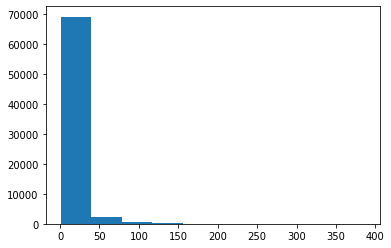

In [80]:
plt.hist(train["Unique Headcount"])

In [81]:
train.describe()["Unique Headcount"]

count    72249.000000
mean         8.337250
std         17.263497
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        387.000000
Name: Unique Headcount, dtype: float64

# From this we observe that the Unique Headcount values are heavily skewed towards the left
- There are many outliers, this could cause a serious concern while training the model
- With a mean of 8, 75% CI at 7 and a maximum value of 387, no model could be expected to fit perfectly to this in a linear fashion
- Since the metric is RMSE, a wrong prediction when the value is > the mean+std deviation could cause high shifts in the RMSE of the model

# Different approaches
## Approach 1
- Initially we trained on the entire train dataset, splitting into train and test within the test dataset itself
- To start off, lets try regular linear regression
- This gives an error of around 15, or in some cases causes the model to go haywire xD
- From the scatterplot and distribution plots, we understand that the Linear Regression model is sensitive to outliers and is unable to output values that are greater than 40
- Since it is sensitive to outliers Linear Regression is not the right choice

In [82]:
x = train.drop("Unique Headcount",axis=1)
y = train["Unique Headcount"]
xtrain,xtest,ytrain,ytest = train_test_split(x,y,shuffle=True,test_size=0.3)
lregressor = LinearRegression()
lregressor.fit(xtrain,ytrain)
preds = lregressor.predict(xtest)
mse = mean_squared_error(ytest, preds)
rmse = math.sqrt(mse)
print(rmse)

15.177953967096117


(array([2.0702e+04, 6.4700e+02, 2.0600e+02, 7.8000e+01, 2.8000e+01,
        9.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  1. ,  38.2,  75.4, 112.6, 149.8, 187. , 224.2, 261.4, 298.6,
        335.8, 373. ]),
 <a list of 10 Patch objects>)

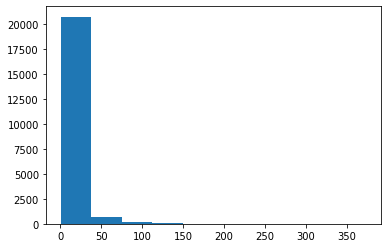

In [83]:
plt.hist(ytest)

(array([  50.,  591., 2622., 5300., 6139., 4182., 1728.,  853.,  178.,
          32.]),
 array([-18.8125    , -12.68515625,  -6.5578125 ,  -0.43046875,
          5.696875  ,  11.82421875,  17.9515625 ,  24.07890625,
         30.20625   ,  36.33359375,  42.4609375 ]),
 <a list of 10 Patch objects>)

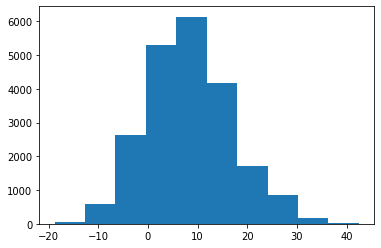

In [84]:
plt.hist(preds)

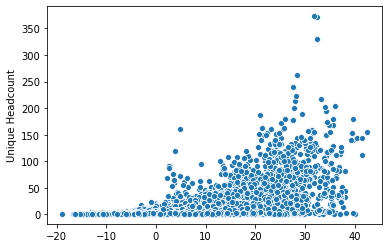

In [85]:
sns.scatterplot(preds,ytest)

In [86]:
print("Predictions: ")
print("Mean =",np.mean(preds))
print("Max =",np.max(preds))
print("Min =",np.min(preds))
print("Std =",np.std(preds))

Predictions: 
Mean = 8.363868223760091
Max = 42.4609375
Min = -18.8125
Std = 8.567320306215997


In [87]:
print("Ytest: ")
print("Mean =",np.mean(ytest.to_numpy()))
print("Max =",np.max(ytest.to_numpy()))
print("Min =",np.min(ytest.to_numpy()))
print("Std =",np.std(ytest.to_numpy()))

Ytest: 
Mean = 8.40327566320646
Max = 373
Min = 1
Std = 17.494635813136412


### Analysis:
- actual vs predicted plot is absolutely not linear and of 45 degrees, indicating this is a bad model
- The statistics of ytest and predictions vary significantly, furthering the fact that this is a bad model and a bad fit

## Approach 2
- Seeing that the values of Unique Headcount are not normalised, this could cause the model to not predict correctly for higher values
- So we thought we'd try normalise the Unique Headcount values and then predict using these values
- However this doesn't seem to give good results either

In [88]:
train_stats_uh = train.describe().transpose()

In [89]:
def norm(x):
    return (x-train_stats_uh["mean"]["Unique Headcount"])/train_stats_uh["std"]["Unique Headcount"]
train["UH"] = train["Unique Headcount"].apply(lambda x:norm(x))
def convert(x):
    return x*train_stats_uh["std"]["Unique Headcount"]+train_stats_uh["mean"]["Unique Headcount"]

In [90]:
x = train.drop(["Unique Headcount", "UH"],axis=1)
y = train["UH"]
xtrain,xtest,ytrain,ytest = train_test_split(x,y,shuffle=True,test_size=0.3)
lregressor = LinearRegression()
lregressor.fit(xtrain,ytrain)
preds = lregressor.predict(xtest)

In [91]:
df = pd.DataFrame(ytest)
df["preds"] = preds
df["Unique Headcount"] = df["UH"].apply(lambda x:convert(x))
df["preds"] = df["preds"].apply(lambda x:convert(x))
mse = mean_squared_error(df["preds"],df["Unique Headcount"])
rmse = math.sqrt(mse)
print(rmse)

14.704512826416654


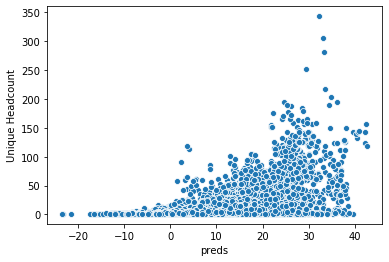

In [92]:
sns.scatterplot(df["preds"],df["Unique Headcount"])

In [93]:
print("Predictions: ")
df["preds"].describe()

Predictions: 


count    21675.000000
mean         8.241374
std          8.566191
min        -23.357451
25%          2.099463
50%          7.932637
75%         13.445492
max         42.577643
Name: preds, dtype: float64

In [94]:
print("Ytest: ")
df["Unique Headcount"].describe()

Ytest: 


count    21675.000000
mean         8.368720
std         17.031187
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        343.000000
Name: Unique Headcount, dtype: float64

### Analysis:
- The actual vs predicted plot is heavily scattered and not in a proper line
- The statistics of ytest and preds vary significantly
- Thus this is a bad model for the given data

## Approach 3
- Tree algorithms like decision trees and random forests are robust to outliers. 
- Here we have experimented with the RandomForestRegressor with 100 estimators

In [95]:
x = train.drop(["Unique Headcount","UH"],axis=1)
y = train["Unique Headcount"]
xtrain,xtest,ytrain,ytest = train_test_split(x,y,shuffle=True,test_size=0.3)
rfregressor = RandomForestRegressor(n_estimators=100,verbose=1)
rfregressor.fit(xtrain,ytrain)
preds = rfregressor.predict(xtest)
mse = mean_squared_error(ytest, preds)
rmse = math.sqrt(mse)
print(rmse)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5.456960057187879


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


(array([2.0718e+04, 6.8700e+02, 1.7100e+02, 6.8000e+01, 2.0000e+01,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([  1. ,  39.6,  78.2, 116.8, 155.4, 194. , 232.6, 271.2, 309.8,
        348.4, 387. ]),
 <a list of 10 Patch objects>)

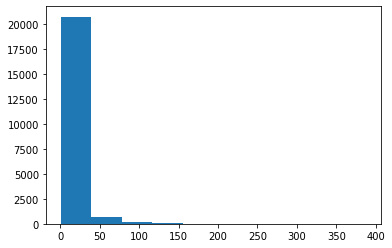

In [96]:
plt.hist(ytest)

(array([2.0664e+04, 6.9100e+02, 2.2200e+02, 6.9000e+01, 1.8000e+01,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00]),
 array([  1.   ,  37.018,  73.036, 109.054, 145.072, 181.09 , 217.108,
        253.126, 289.144, 325.162, 361.18 ]),
 <a list of 10 Patch objects>)

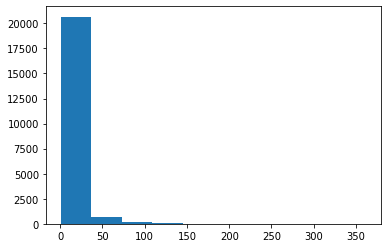

In [97]:
plt.hist(preds)

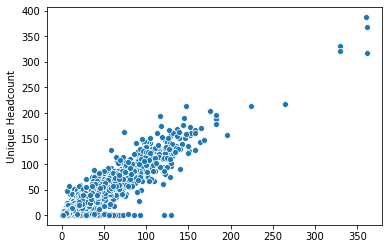

In [98]:
sns.scatterplot(preds,ytest)

In [99]:
print("Predictions: ")
print("Mean =",np.mean(preds))
print("Max =",np.max(preds))
print("Min =",np.min(preds))
print("Std =",np.std(preds))

Predictions: 
Mean = 8.487280276816609
Max = 361.18
Min = 1.0
Std = 16.6851654566191


In [100]:
print("Ytest: ")
print("Mean =",np.mean(ytest.to_numpy()))
print("Max =",np.max(ytest.to_numpy()))
print("Min =",np.min(ytest.to_numpy()))
print("Std =",np.std(ytest.to_numpy()))

Ytest: 
Mean = 8.305467128027681
Max = 387
Min = 1
Std = 17.310095996201415


### Analysis:
- The actual vs predicted plot shows a linear graph, however it has high variability, which can be improved
- This model is robust to outliers
- A low error indicates this is a decent model to use

## Approach 4
- We assign different categories to the samples, hoping it will learn to better fit the data provided
- Additionally we also tried using Principle Components of the dataset, since 200 columns can be a bit too much for any model

In [101]:
def assign_cat(x):
    if x<=10:
        return "uh<=10"
    if x<=25:
        return "10<uh<=25"
    else:
        return "uh>25"

In [102]:
train

,Fiscal Year-2008/09,Fiscal Year-2009/10,Fiscal Year-2010/11,Fiscal Year-2011/12,Fiscal Year-2012/13,Fiscal Year-2013/14,Fiscal Year-2014/15,Fiscal Year-2015/16,Term Type-Fall term,Term Type-Spring term,...,Attendance-Part-Time,Attendance-Unknown Attendance,Visa Status-Canadian,Visa Status-International,Visa Status-Canadian Permanent Resident,Gender-Male,Gender-Female,Gender-Another Gender Identity,Unique Headcount,UH
0,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,5,-0.193313
1,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,7,-0.077461
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,-0.425015
3,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,3,-0.309164
4,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,11,0.154242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72244,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,25,0.965201
72245,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,27,1.081053
72246,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,1,-0.425015
72247,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,30,1.254830


In [103]:
train["Category"] = train["Unique Headcount"].apply(lambda x:assign_cat(x))

In [104]:
x = train.drop(["Unique Headcount","UH","Category"],axis=1)
y = train[["Unique Headcount","Category"]]
xtrain,xtest,ytrain,ytest = train_test_split(x,y,shuffle=True,test_size=0.3)
rfclassifier = RandomForestClassifier(n_estimators=300)
rfclassifier.fit(xtrain,ytrain["Category"])
rfy_pred = rfclassifier.predict(xtest)
print(confusion_matrix(ytest["Category"], rfy_pred,labels = ['uh<=10','10<uh<=25','uh>25']))
print(classification_report(ytest["Category"], rfy_pred))
print(accuracy_score(ytest["Category"], rfy_pred))

[[17376   283    69]
 [  952  1227   168]
 [   65   200  1335]]
              precision    recall  f1-score   support

   10<uh<=25       0.72      0.52      0.60      2347
      uh<=10       0.94      0.98      0.96     17728
       uh>25       0.85      0.83      0.84      1600

    accuracy                           0.92     21675
   macro avg       0.84      0.78      0.80     21675
weighted avg       0.91      0.92      0.91     21675

0.9198615916955017


In [105]:
 def train_model(xtrain,ytrain,i):
    rf = RandomForestRegressor(n_estimators=100*i)
    rf.fit(xtrain,ytrain)
    predictions_train = rf.predict(xtrain)
    return rf

In [106]:
xtrain["cat"] = ytrain["Category"]
xtrain["uh"] = ytrain["Unique Headcount"]
xtrain1 = xtrain[xtrain['uh']<=10]
ytrain1 = xtrain1["uh"]
xtrain1 = xtrain1.drop(['cat',"uh"],axis=1)
xtrain2 = xtrain[xtrain['uh']<=25]
xtrain2 = xtrain2[xtrain2['uh']>10]
ytrain2 = xtrain2["uh"]
xtrain2 = xtrain2.drop(['cat',"uh"],axis=1)
xtrain3 = xtrain[xtrain['uh']>25]
ytrain3 = xtrain3["uh"]
xtrain3 = xtrain3.drop(['cat',"uh"],axis=1)

C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
model1 = train_model(xtrain1,ytrain1,1)
model2 = train_model(xtrain2,ytrain2,2)
model3 = train_model(xtrain3,ytrain3,3)

In [131]:
count = 0
def predict(x):
    global count
    if(count%1000==0):
        print(count)
    count+=1
    cat = x.get(key="Category")
#     x = np.squeeze(np.array(x[:-1]))
#     x = np.reshape(x,(1,-1))
    x = train[x.name:x.name+1]
    print("Actual: ", x["Category"],x["Unique Headcount"])
    print("Predicted: ",model1.predict(x)[0],model2.predict(x)[0],model3.predict(x)[0])
    x = x.drop(["Category","UH","Unique Headcount"],axis=1)
    if cat=='uh<=10':
        return model1.predict(x)[0]
    if cat=='10<uh<=25':
        return model2.predict(x)[0] 
    if cat=='uh>25':
        return model3.predict(x)[0] 
    return 1

In [109]:
xtest["Category"] = rfy_pred
xtest["Unique Headcount"] = xtest.apply(lambda x: predict(x),axis=1)

C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
mse = mean_squared_error(xtest["Unique Headcount"],ytest["Unique Headcount"])
rmse = math.sqrt(mse)
print(rmse)

6.005914969674939


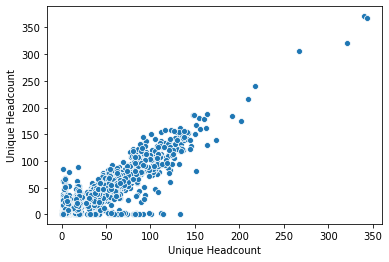

In [111]:
sns.scatterplot(xtest["Unique Headcount"],ytest["Unique Headcount"])

In [112]:
print("Predictions: ")
xtest["Unique Headcount"].describe()

Predictions: 


count    21675.000000
mean         8.141014
std         16.712006
min          1.000000
25%          1.560000
50%          2.840000
75%          6.090000
max        343.250000
Name: Unique Headcount, dtype: float64

In [113]:
print("Ytest: ")
ytest["Unique Headcount"].describe()

Ytest: 


count    21675.000000
mean         8.244475
std         16.847458
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        371.000000
Name: Unique Headcount, dtype: float64

### Analysis:
- This model has a worse error than the RF prediction model
- However its actual vs predicted plot too is slightly linear and robust to outliers, indicating it is a good fit for the given data
- Since it is a two part model, the accuracy of the first heavily affects the second. Improving will improve the model

## Approach 5
- Same approach as #4, but with PCA
- Using PCA since PCA clearly allows for the classification model to learn features better and give a higher accuracy

In [114]:
data = pd.concat((train.drop(["Unique Headcount","UH","Category"],axis=1),test),axis=0)
data.shape

(83173, 201)

In [115]:
data

,Fiscal Year-2008/09,Fiscal Year-2009/10,Fiscal Year-2010/11,Fiscal Year-2011/12,Fiscal Year-2012/13,Fiscal Year-2013/14,Fiscal Year-2014/15,Fiscal Year-2015/16,Term Type-Fall term,Term Type-Spring term,...,WorkTerm-Work Term,Attendance-Full-Time,Attendance-Part-Time,Attendance-Unknown Attendance,Visa Status-Canadian,Visa Status-International,Visa Status-Canadian Permanent Resident,Gender-Male,Gender-Female,Gender-Another Gender Identity
0,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10919,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
10920,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,1,0,0
10921,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
10922,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0


In [116]:
pca = PCA(n_components=80)
pcomp  = pca.fit_transform(data)
print(pcomp.shape)
pclist = []
for i in range(pcomp.shape[1]):
    pclist.append('pc'+str(i+1))
datapca = pd.DataFrame(pcomp,columns = pclist)

(83173, 80)


In [117]:
trainpca = datapca[:train.shape[0]]
testpca = datapca[train.shape[0]:]
trainpca["Unique Headcount"] = headcount
trainpca["Category"] = train["Unique Headcount"].apply(lambda x:assign_cat(x))

C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [118]:
x = trainpca.drop(["Unique Headcount","Category"],axis=1)
y = trainpca[["Unique Headcount","Category"]]
xtrain,xtest,ytrain,ytest = train_test_split(x,y,shuffle=True,test_size=0.3)
rfclassifier = RandomForestClassifier(n_estimators=300)
rfclassifier.fit(xtrain,ytrain["Category"])
rfy_pred = rfclassifier.predict(xtest)
print(confusion_matrix(ytest["Category"], rfy_pred,labels = ['uh<=10','10<uh<=25','uh>25']))
print(classification_report(ytest["Category"], rfy_pred))
print(accuracy_score(ytest["Category"], rfy_pred))

[[17410   286    52]
 [  780  1423   142]
 [   54   190  1338]]
              precision    recall  f1-score   support

   10<uh<=25       0.75      0.61      0.67      2345
      uh<=10       0.95      0.98      0.97     17748
       uh>25       0.87      0.85      0.86      1582

    accuracy                           0.93     21675
   macro avg       0.86      0.81      0.83     21675
weighted avg       0.93      0.93      0.93     21675

0.9306113033448674


In [129]:
xtest

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc72,pc73,pc74,pc75,pc76,pc77,pc78,pc79,pc80,Category
52501,-0.721654,0.844125,-0.087402,-0.702924,0.651937,-0.156917,0.445313,-0.723633,-0.592176,0.073825,...,-0.128545,0.009739,-0.003617,-0.014736,0.007960,-0.000906,-0.022140,0.004796,-0.002077,uh<=10
66029,-0.678745,0.482155,-0.558744,0.525666,0.112068,0.446808,-0.038402,-0.168559,-0.849591,-0.713584,...,0.241356,-0.011128,-0.044854,0.052561,-0.035040,-0.006298,0.095560,0.000601,0.099397,uh>25
47876,-0.710931,-0.037811,0.916971,-0.708498,-0.780786,-0.122880,0.144109,0.828136,-0.139117,-0.136986,...,0.005912,0.001171,-0.012367,-0.007112,0.005661,0.000270,-0.007679,-0.003736,-0.004828,uh<=10
52740,0.171637,-0.168069,-1.101542,-0.183532,0.746078,-0.657119,-0.743165,-0.365019,0.433292,-0.273571,...,-0.016677,0.013743,-0.059370,-0.006787,-0.001901,0.018891,-0.044605,0.134311,0.024401,uh<=10
67581,0.139426,0.493786,-0.538292,-0.742415,-0.138743,0.801005,-0.642175,-0.715356,0.128704,-0.782875,...,0.079382,-0.012622,-0.002706,0.007287,-0.007262,0.012414,0.018685,-0.013625,0.023603,uh<=10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36355,1.783620,-0.270083,0.586137,0.887583,-0.592501,-0.180901,0.875486,-0.067001,0.192511,-0.357962,...,0.008580,0.003354,0.017450,0.052243,0.007430,0.012698,0.006829,0.020731,-0.014456,uh<=10
53558,-0.678311,-0.685511,0.300046,0.172668,0.764573,-0.370616,0.690440,0.339510,-0.314036,-0.133429,...,0.035700,-0.023925,0.005741,-0.011580,0.045428,-0.031592,-0.031734,0.085954,-0.062574,uh<=10
37855,-0.801260,-0.086996,0.886976,-0.659012,-0.793588,0.015631,0.377591,0.264605,-0.087616,0.594290,...,0.003795,0.003071,-0.003980,0.001609,0.001651,-0.004021,0.004634,0.002469,-0.005434,uh<=10
22778,1.525170,-0.221799,0.724258,0.851307,0.115259,0.381013,-0.468196,0.267609,-0.502019,-0.337464,...,0.008351,-0.002697,0.003073,0.017913,-0.057339,0.046485,-0.029405,-0.020396,0.006976,uh<=10


In [132]:
xtest["Category"] = rfy_pred
count=0
# xtest = xtest.drop("Unique Headcount",axis=1)
xtest["Unique Headcount"] = xtest.apply(lambda x: predict(x),axis=1)

0
Actual:  52501    uh<=10
Name: Category, dtype: object 52501    1
Name: Unique Headcount, dtype: int64


ValueError: could not convert string to float: 'uh<=10'

In [120]:
mse = mean_squared_error(xtest["Unique Headcount"],ytest["Unique Headcount"])
rmse = math.sqrt(mse)
print(rmse)

5.764629851795092


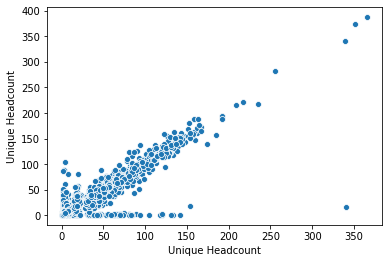

In [121]:
sns.scatterplot(xtest["Unique Headcount"],ytest["Unique Headcount"])

In [122]:
print("Predictions: ")
xtest["Unique Headcount"].describe()

Predictions: 


count    21675.000000
mean         8.061546
std         16.983984
min          1.000000
25%          1.370000
50%          2.700000
75%          6.270000
max        365.406667
Name: Unique Headcount, dtype: float64

In [123]:
print("Ytest: ")
ytest["Unique Headcount"].describe()

Ytest: 


count    21675.000000
mean         8.152111
std         16.972862
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max        387.000000
Name: Unique Headcount, dtype: float64

## Analysis:
- The variability of the actual vs predicted plot is much less than the other plots, indicating this is a good fit
- Also the general statistics of the predictions and ytest match, indicating it is a good fit

# From this we understand that
- RF classifier performed best with PCA
- So it would be best to use rfclassifier for predicting class and the rf regressor models to predict the values
- We used this to submit our predictions

In [61]:
xtest["Category"] = ytest["Category"]

C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
xtest["Unique Headcount"] = xtest.apply(lambda x: predict(x),axis=1)

22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


C:\Users\Andrea Solomon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
mse = mean_squared_error(xtest["Unique Headcount"],ytest["Unique Headcount"])
rmse = math.sqrt(mse)
print(rmse)

2.794931744238707


In [64]:
print("Predictions: ")
xtest["Unique Headcount"].describe()

Predictions: 


count    21675.000000
mean         8.390700
std         16.808821
min          1.000000
25%          1.390000
50%          2.730000
75%          6.700000
max        352.940000
Name: Unique Headcount, dtype: float64

In [65]:
print("Ytest: ")
ytest["Unique Headcount"].describe()

Ytest: 


count    21675.000000
mean         8.329689
std         17.036984
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        368.000000
Name: Unique Headcount, dtype: float64

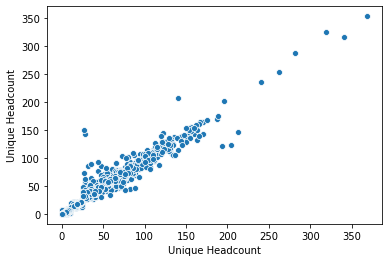

In [66]:
sns.scatterplot(ytest["Unique Headcount"],xtest["Unique Headcount"])